In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import keras
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, Normalizer, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from sklearn.preprocessing import PowerTransformer
from keras.regularizers import l1_l2

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

2024-06-12 19:51:06.145870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 19:51:06.890421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
vix_data = yf.download('^VIX', start='2008-01-01')
vix_data['VIX_close'] = vix_data['Adj Close']

tnx_data = yf.download('^TNX', start='2008-01-01')
tnx_data['10_Y_close'] = tnx_data['Adj Close'] / 100

irx_data = yf.download('^IRX', start='2008-01-01')
irx_data['3_M_close'] = irx_data['Adj Close'] / 100

vol_df = pd.read_csv('/home/ranksjupyter/notebooks/Ranks/sector_models/vols_pred/volatility_df.csv', 
                     parse_dates=['Date'], index_col='Date')

volatility_df = pd.merge_asof(vol_df, vix_data['VIX_close'], left_index=True, right_index=True, direction='nearest')
volatility_df = pd.merge_asof(volatility_df, tnx_data['10_Y_close'], left_index=True, right_index=True, direction='nearest')
volatility_df = pd.merge_asof(volatility_df, irx_data['3_M_close'], left_index=True, right_index=True, direction='nearest')

volatility_df['Slope'] = volatility_df['10_Y_close'] - volatility_df['3_M_close']
volatility_df = volatility_df.set_index(vol_df.index)
volatility_df.isna().sum()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Recovered_vol                    0
Risk_premium                     0
Risk_preference                  0
Risk_neutral_skewness            0
Risk_neutral_kurtosis            0
Recovered_skewness               0
Recovered_kurtosis               0
USA_10_y_treasuries              0
Effective_Fed_Funds_Rate_true    0
Consumer_Price_Index_true        0
Producer_Price_Index_true        0
Unemployment_Rate_true           0
GDP_true                         0
Industrial_Production_true       0
Mortgage_Rates_true              0
Realized_Volatility              0
VIX_close                        0
10_Y_close                       0
3_M_close                        0
Slope                            0
dtype: int64

In [3]:
volatility_df = volatility_df[['Recovered_vol', 'Risk_premium', 'Risk_preference', 
                               'USA_10_y_treasuries', 'Mortgage_Rates_true', 'VIX_close', 
                               'Slope', 'Realized_Volatility']]

volatility_df = volatility_df.replace([0], 1e-6)

volatility_df = volatility_df / volatility_df.shift(1) - 1

lag = -5
volatility_df[f'Realized_Volatility_(t+{abs(lag)})'] = volatility_df['Realized_Volatility'].shift(lag)
volatility_df = volatility_df.dropna()
# volatility_df.drop('Realized_Volatility', axis=1, inplace=True)
print(len(volatility_df))
volatility_df.head(10)

3357


,Recovered_vol,Risk_premium,Risk_preference,USA_10_y_treasuries,Mortgage_Rates_true,VIX_close,Slope,Realized_Volatility,Realized_Volatility_(t+5)
Date,,,,,,,,,
2010-01-05,-0.024188,-0.842892,0.119724,-0.022390,0.000000,-0.034431,-0.024036,-0.029937,0.031692
2010-01-06,0.001425,0.247562,0.002371,0.014114,0.000000,-0.009819,0.018403,-0.015344,0.029962
2010-01-07,0.007015,0.222614,0.014305,0.003676,0.000000,-0.005219,0.003720,0.005156,-0.022161
2010-01-08,0.030061,-0.979034,-0.110890,-0.003663,0.000000,-0.048793,-0.002383,-0.052279,0.046408
2010-01-11,0.030583,98.432695,0.030537,0.002626,0.022267,-0.031991,0.006635,-0.006034,0.073188
2010-01-12,-0.037054,0.438333,-0.051378,-0.025930,0.000000,0.039886,-0.030055,0.031692,-0.011969
2010-01-13,0.161288,-1.216182,0.260483,0.017209,0.000000,-0.021918,0.014678,0.029962,0.137014
2010-01-14,0.012751,0.520871,0.022884,-0.012953,0.000000,-0.012325,-0.011787,-0.022161,0.125819
2010-01-15,-0.231002,-4.854506,-0.308144,-0.015533,0.000000,0.015882,-0.018433,0.046408,0.002256


In [4]:
# Стандартизация, нормализация, замена выбросов медианой

values_clear = volatility_df.copy()

train_size = int(len(values_clear) * 0.7)
val_size = int(len(values_clear) * 0.15)
test_size = len(values_clear) - train_size - val_size

train = values_clear.iloc[:train_size]
val = values_clear.iloc[train_size:train_size + val_size]
test = values_clear.iloc[train_size + val_size:]

# Обучаем стандартизатор, нормализатор и изолейшн форест на тренировочных данных
transformer = PowerTransformer(method='yeo-johnson')
transformer.fit(train)
train_transformed = transformer.transform(train)

scaler = MinMaxScaler(feature_range=(1e-6, 1))
scaler.fit(train_transformed)
train_scaled = scaler.transform(train_transformed)

isolation_forest = IsolationForest(n_estimators=1000, contamination=0.01, random_state=42) # 0.01
isolation_forest.fit(train_scaled)

normalizer = Normalizer()
normalizer.fit(train_scaled)

# Применяем стандартизатор, нормализатор и изолейшн форест на тренировочных, валидационных и тестовых данных
train_isolation_forest = isolation_forest.predict(train_scaled)
train_normalized = normalizer.transform(train_scaled)

val_transformed = transformer.transform(val)
val_scaled = scaler.transform(val_transformed)
val_isolation_forest = isolation_forest.predict(val_scaled)
val_normalized = normalizer.transform(val_scaled)

test_transformed = transformer.transform(test)
test_scaled = scaler.transform(test_transformed)
test_isolation_forest = isolation_forest.predict(test_scaled)
test_normalized = normalizer.transform(test_scaled)

# Считаем метрику
train_values = np.median(train_normalized, axis=0)
val_values = np.median(val_normalized, axis=0)
test_values = np.median(test_normalized, axis=0)

# Заполняем выбросы медианой
train_normalized[train_isolation_forest == -1] = train_values
val_normalized[val_isolation_forest == -1] = val_values
test_normalized[test_isolation_forest == -1] = test_values

y_train = train_normalized[:, -1:]
y_train = np.squeeze(y_train)
X_train = np.delete(train_normalized, -1, axis=1)

y_val = val_normalized[:, -1:]
y_val = np.squeeze(y_val)
X_val = np.delete(val_normalized, -1, axis=1)

y_test = test_normalized[:, -1:]
y_test = np.squeeze(y_test)
X_test = np.delete(test_normalized, -1, axis=1)

# Reshape
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(2349, 1, 8) (2349,) (503, 1, 8) (503,) (505, 1, 8) (505,)


In [5]:
# LSTM

In [6]:
# custom_logcosh

penalty = 5
quantile_threshold = 75
quantile = tf.constant(np.percentile(y_train, quantile_threshold), dtype=tf.float32)

def custom_logcosh(y_true, y_pred):
    error = y_true - y_pred
    mask = tf.cast(y_true > quantile, tf.float32)
    weighted_error = error * (1 + penalty * mask * (y_true - quantile))
    return tf.reduce_sum(tf.math.log(tf.math.cosh(weighted_error)))

In [7]:
n_units = 8
dropout_rate = 0.5
recurrent_dropout_rate = 0.5
activation = 'tanh'
seed = 1
input_model = (X_train.shape[1], X_train.shape[2])
l1_reg = 0.00
l2_reg = 0.00

model = Sequential()

model.add(LSTM(
    n_units,
    activation=activation, 
    return_sequences=True,
    input_shape=input_model,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
    seed=seed,
))
model.add(Dropout(dropout_rate))

model.add(LSTM(
    n_units,
    activation=activation,
    return_sequences=True,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(LSTM(
    n_units,
    activation=activation,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(Dense(1))
model.add(Activation('linear'))

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=custom_logcosh) # keras.losses.log_cosh

history = model.fit(X_train,
                    y_train,
                    epochs=500,
                    batch_size=4,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    shuffle=False,
                    callbacks=[early_stopping])

# Предсказание значений на валидационной выборке
val_pred = model.predict(X_val)
print(f'MSE val: {mean_squared_error(y_val, val_pred):.4f}')
print(f'MAE val: {mean_absolute_error(y_val, val_pred):.4f}')
print(f'R2 val: {r2_score(y_val, val_pred):.4f}')
print(f'MAPE val: {mean_absolute_percentage_error(y_val, val_pred):.4f}')

# Предсказание значений на тестовой выборке
y_pred = model.predict(X_test)
print(f'MSE test: {mean_squared_error(y_test, y_pred):.4f}')
print(f'MAE test: {mean_absolute_error(y_test, y_pred):.4f}')
print(f'R2 test: {r2_score(y_test, y_pred):.4f}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_pred):.4f}')

Epoch 1/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2505 - val_loss: 0.1204
Epoch 2/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0945 - val_loss: 0.0188
Epoch 3/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0384 - val_loss: 0.0072
Epoch 4/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0298 - val_loss: 0.0055
Epoch 5/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0221 - val_loss: 0.0038
Epoch 6/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0174 - val_loss: 0.0027
Epoch 7/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0142 - val_loss: 0.0026
Epoch 8/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124 - val_loss: 0.0024
Epoch 9/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098 - val_loss: 0.0022
Epoch 10/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092 - val_loss: 0.0020
Epoch 11/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069 - val_loss: 0.0019
Epoch 12/500
588/588 ━━━━━━━━━━━━━━━━━━━━

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 69/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 70/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 71/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 72/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 73/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 74/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 75/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 76/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 77/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 78/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 79/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 

Epoch 135/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 136/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 137/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 138/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 139/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 140/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 141/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 142/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 143/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 144/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 145/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 146/500
588/588

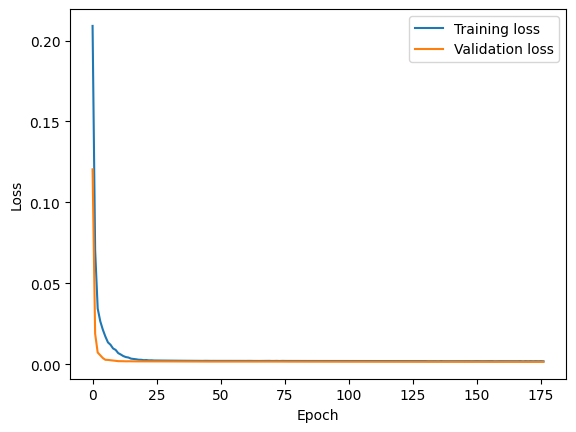

In [8]:
# График лосса

train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots()
ax.plot(train_loss, label='Training loss')
ax.plot(val_loss, label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

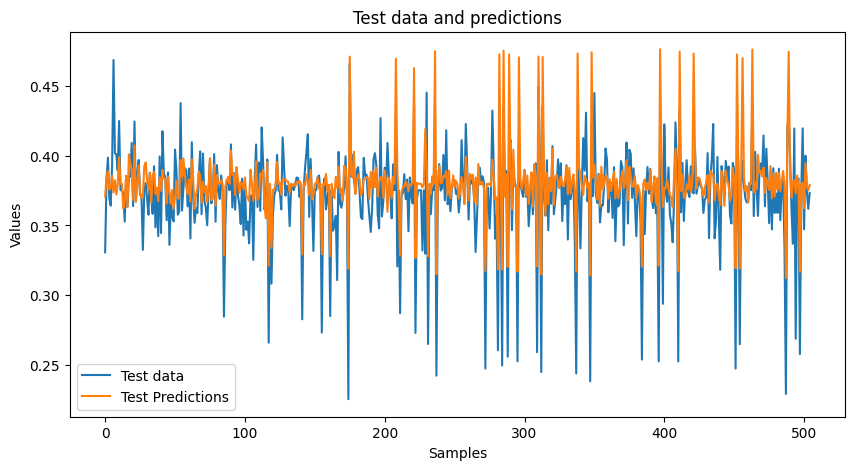

In [9]:
# Построение графика тестовой выборки и прогнозов

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Test data')
plt.plot(y_pred, label='Test Predictions')
plt.title('Test data and predictions')
plt.xlabel('Samples')
plt.ylabel('Values') 
plt.legend()
plt.show()

In [10]:
# keras.losses.log_cosh

n_units = 8
dropout_rate = 0.5
recurrent_dropout_rate = 0.5
activation = 'tanh'
seed = 1
input_model = (X_train.shape[1], X_train.shape[2])
l1_reg = 0.00
l2_reg = 0.00

model = Sequential()

model.add(LSTM(
    n_units,
    activation=activation, 
    return_sequences=True,
    input_shape=input_model,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
    seed=seed,
))
model.add(Dropout(dropout_rate))

model.add(LSTM(
    n_units,
    activation=activation,
    return_sequences=True,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(LSTM(
    n_units,
    activation=activation,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(Dense(1))
model.add(Activation('linear'))

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=keras.losses.log_cosh) # keras.losses.log_cosh

history = model.fit(X_train,
                    y_train,
                    epochs=500,
                    batch_size=4,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    shuffle=False,
                    callbacks=[early_stopping])

# Предсказание значений на валидационной выборке
val_pred_log_cosh = model.predict(X_val)
print(f'MSE val: {mean_squared_error(y_val, val_pred_log_cosh):.4f}')
print(f'MAE val: {mean_absolute_error(y_val, val_pred_log_cosh):.4f}')
print(f'R2 val: {r2_score(y_val, val_pred):.4f}')
print(f'MAPE val: {mean_absolute_percentage_error(y_val, val_pred):.4f}')

# Предсказание значений на тестовой выборке
y_pred_log_cosh = model.predict(X_test)
print(f'MSE test: {mean_squared_error(y_test, y_pred_log_cosh):.4f}')
print(f'MAE test: {mean_absolute_error(y_test, y_pred_log_cosh):.4f}')
print(f'R2 test: {r2_score(y_test, y_pred_log_cosh):.4f}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_pred_log_cosh):.4f}')

Epoch 1/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0607 - val_loss: 0.0333
Epoch 2/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0263 - val_loss: 0.0054
Epoch 3/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0087 - val_loss: 0.0022
Epoch 4/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0061 - val_loss: 0.0011
Epoch 5/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0050 - val_loss: 7.7236e-04
Epoch 6/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039 - val_loss: 7.2591e-04
Epoch 7/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035 - val_loss: 5.6611e-04
Epoch 8/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0027 - val_loss: 5.2363e-04
Epoch 9/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0023 - val_loss: 4.3902e-04
Epoch 10/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - val_loss: 4.4870e-04
Epoch 11/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - val_loss: 4.2179e-04
Epoch 12/500


588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4634e-04 - val_loss: 3.3993e-04
Epoch 65/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4193e-04 - val_loss: 3.3906e-04
Epoch 66/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4635e-04 - val_loss: 3.3818e-04
Epoch 67/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.5331e-04 - val_loss: 3.3720e-04
Epoch 68/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4739e-04 - val_loss: 3.3561e-04
Epoch 69/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3924e-04 - val_loss: 3.3459e-04
Epoch 70/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3866e-04 - val_loss: 3.3370e-04
Epoch 71/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3351e-04 - val_loss: 3.3228e-04
Epoch 72/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3871e-04 - val_loss: 3.3119e-04
Epoch 73/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3331e-04 - val_loss: 3.3027e-04
Epoch 74/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Epoch 127/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0881e-04 - val_loss: 3.0062e-04
Epoch 128/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1408e-04 - val_loss: 3.0127e-04
Epoch 129/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1076e-04 - val_loss: 2.9976e-04
Epoch 130/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2296e-04 - val_loss: 3.0032e-04
Epoch 131/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0868e-04 - val_loss: 2.9963e-04
Epoch 132/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0752e-04 - val_loss: 2.9900e-04
Epoch 133/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1298e-04 - val_loss: 2.9919e-04
Epoch 134/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0799e-04 - val_loss: 2.9797e-04
Epoch 135/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1787e-04 - val_loss: 2.9835e-04
Epoch 136/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1253e-04 - val_loss: 2.9793e-04
Epoch 137/500
588/588 ━━━━━━━━

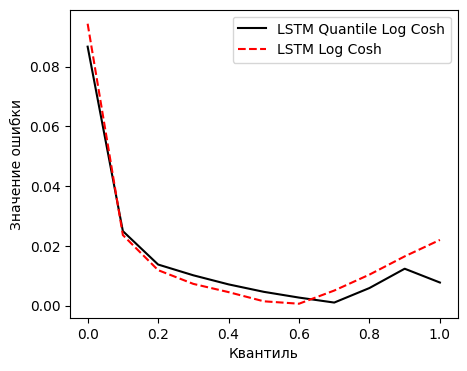

In [11]:
# LSTM quantile logcosh
quan = []
for q in np.arange(0, 1.1, 0.1):
    quantile_error = np.abs(np.quantile(y_test, q) - np.quantile(y_pred, q))
    quan.append(quantile_error)
quan_df = pd.DataFrame(quan, columns=['LSTM quantile logcosh'])
index = np.arange(0, len(quan_df)*0.1, 0.1)
quan_df.set_index(index, inplace=True)

# LSTM logcosh
quan_log_cosh = []
for q in np.arange(0, 1.1, 0.1):
    quantile_error = np.abs(np.quantile(y_test, q) - np.quantile(y_pred_log_cosh, q))
    quan_log_cosh.append(quantile_error)

quan_df_log_cosh = pd.DataFrame(quan_log_cosh, columns=['LSTM logcosh'])
index = np.arange(0, len(quan_df_log_cosh)*0.1, 0.1)
quan_df_log_cosh.set_index(index, inplace=True)

quan_df['LSTM logcosh'] = quan_df_log_cosh

plt.figure(figsize=(5, 4))
plt.plot(quan_df['LSTM quantile logcosh'], color='black', label='LSTM Quantile Log Cosh')
plt.plot(quan_df['LSTM logcosh'], color='red', label='LSTM Log Cosh', linestyle='--')
plt.legend()
plt.xlabel('Квантиль')
plt.ylabel('Значение ошибки')

plt.savefig('lstm_q_errors_rob_check.svg', format='svg')

plt.show()